In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [1]:
directory='.'
# directory='/content/drive/MyDrive/esn2sparse'; 
# !cp "/content/drive/MyDrive/esn2sparse/params.py" "."

In [2]:
import torch
import numpy as np
import sympy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as pl
import torchvision
import torchvision.datasets as datasets
import time
import torch.jit as jit
from torch import nn
from torch import optim
from os.path import exists
import gc
import importlib
import params_feedback as par
import time
import os
device = 'cpu'
# device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
mnist_trainset = datasets.MNIST(root=directory+'/data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root=directory+'/data', train=False, download=True, transform=None)

In [4]:
X_te=mnist_testset.data               ## Test set images
y_te=mnist_testset.test_labels        ## Test set labels

N_o=10                                ## Number of output nodes/classes
N_te=y_te.size()[0]                   ## Number of test samples
Y_te=torch.zeros([N_te,N_o])          ## Initialisation of the one-hot encoded labels for the test set
Y_te[np.arange(0,N_te),y_te]=1        ## From labels to one-hot encoded labels for the test set

X_tr=mnist_trainset.data              ## Train set images
y_tr=mnist_trainset.train_labels      ## Train labels 
N_tr=y_tr.size()[0]                   ## Number of training samples
N_i = X_tr.size()[1]                  ## Number of inputs to ESN

Y_tr=torch.zeros([N_tr,N_o])          ## Initialisation of one-hot encoded labels for training
Y_tr[np.arange(0,N_tr),y_tr]=1        ## From labels to one-hot encoded labels for the training set

N_val=10000                           ## Here I take out N_val samples from the training set and use them for validation
i_val=np.random.permutation(np.arange(0,N_tr))[0:N_val]

X_val=X_tr[i_val,:,:]
Y_val=Y_tr[i_val,:]

i_tr=np.delete(np.arange(0,N_tr),i_val)
N_tr=N_tr-N_val

X_tr=X_tr[i_tr,:,:]
Y_tr=Y_tr[i_tr,:]

T=X_tr.size()[2]
N_in=X_tr.size()[1]

## Normalisation and conversion to float
X_M=255
# X_tr=torch.reshape( (X_tr.float()/X_M),[-1,784]) 
# X_val=torch.reshape((X_val.float()/X_M),[-1,784])
# X_te=torch.reshape((X_te.float()/X_M),[-1,784])
X_tr=torch.reshape( (X_tr.float()),[-1,784]).to(device)
X_val=torch.reshape((X_val.float()),[-1,784]).to(device)
X_te=torch.reshape((X_te.float()),[-1,784]).to(device)

for j in range(X_tr.shape[0]):
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= torch.std(X_tr[j,:])

for j in range(X_val.shape[0]):
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= torch.std(X_val[j,:])

for j in range(X_te.shape[0]):
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= torch.std(X_te[j,:])

X_tr=torch.reshape( (X_tr),[-1,28,28]) 
X_val=torch.reshape((X_val),[-1,28,28])
X_te=torch.reshape((X_te),[-1,28,28])

Y_tr=Y_tr.float().to(device)
Y_val=Y_val.float().to(device)
Y_te=Y_te.float().to(device)

print(f'X_tr shape = {X_tr.shape},    Y_tr shape = {Y_tr.shape}')


/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/jb739/apps/anaconda3/envs/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


X_tr shape = torch.Size([50000, 28, 28]),    Y_tr shape = torch.Size([50000, 10])


In [ ]:
# Add random contrast transformations to input data (OLD VERSION - results in outlines)
for j in range(X_tr.shape[0]):
    X_tr[j,X_tr[j,:]==X_tr[j,:].min()] = X_tr[j,X_tr[j,:]==X_tr[j,:].min()] + torch.rand(1).to(device) * torch.tensor(2.).to(device) * (X_tr[j,:].max() - X_tr[j,:].min())
for j in range(X_val.shape[0]):
    X_val[j,X_val[j,:]==X_val[j,:].min()] = X_val[j,X_val[j,:]==X_val[j,:].min()] + torch.rand(1).to(device) * torch.tensor(2.).to(device) * (X_val[j,:].max() - X_val[j,:].min())
for j in range(X_te.shape[0]):
    X_te[j,X_te[j,:]==X_te[j,:].min()] = X_te[j,X_te[j,:]==X_te[j,:].min()] + torch.rand(1).to(device) * torch.tensor(2.).to(device) * (X_te[j,:].max() - X_te[j,:].min())

# Z-score inputs
for j in range(X_tr.shape[0]):
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= torch.std(X_tr[j,:])

for j in range(X_val.shape[0]):
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= torch.std(X_val[j,:])

for j in range(X_te.shape[0]):
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= torch.std(X_te[j,:])

In [ ]:
# Add random contrast transformations to input data
contrast_mean = torch.tensor(0.5).to(device)
contrast_range = torch.tensor(0.99).to(device)
# Training data
for j in range(X_tr.shape[0]):
    # Rescale values to range 0-1
    X_tr[j,:] -= torch.min(X_tr[j,:])
    X_tr[j,:] /= torch.max(X_tr[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_tr[j,:] = torch.tensor(1.0).to(device) - X_tr[j,:]
    # Z-score
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= (torch.std(X_tr[j,:]) / (contrast_mean + contrast_range*(torch.rand(1).to(device) - torch.tensor(0.5).to(device))))

# Validation data
for j in range(X_val.shape[0]):
    # Rescale values to range 0-1
    X_val[j,:] -= torch.min(X_val[j,:])
    X_val[j,:] /= torch.max(X_val[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_val[j,:] = torch.tensor(1.0).to(device) - X_val[j,:]
    # Z-score
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= (torch.std(X_val[j,:]) / (contrast_mean + contrast_range*(torch.rand(1).to(device) - torch.tensor(0.5).to(device))))

# Test data
for j in range(X_te.shape[0]):
    # Rescale values to range 0-1
    X_te[j,:] -= torch.min(X_te[j,:])
    X_te[j,:] /= torch.max(X_te[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_te[j,:] = torch.tensor(1.0).to(device) - X_te[j,:]
    # Z-score
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= (torch.std(X_te[j,:]) / (contrast_mean + contrast_range*(torch.rand(1).to(device) - torch.tensor(0.5).to(device))))

In [ ]:
# IF NOT USING ESN
# Make inputs 2800-dim and z-score
from scipy import stats
with torch.no_grad():
    w = torch.randn([784, par.N_esn*28]).to(device)/torch.sqrt(torch.tensor(par.N_esn*28+784)).to(device)
    batchsize = torch.tensor(100).to(device)
    # Operate on batches of data to save GPU-memory
    # Training data
    nbatch = torch.ceil(X_tr.shape[0]/batchsize).int()
    temp = torch.zeros(batchsize, par.N_esn*28).to(device)
    perm = torch.zeros(X_tr.shape[0], par.N_esn*28).cpu()
    for j in range(nbatch):    
        temp = torch.matmul(X_tr[j*batchsize:min((j+1)*batchsize,X_tr.shape[0]),:,:].reshape(batchsize, X_tr.shape[1]*X_tr.shape[2]), w)
        temp -= torch.matmul(temp.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
        temp /= temp.std()
        perm[j*batchsize:min((j+1)*batchsize,X_tr.shape[0]), :] = torch.clone(temp).to(device)
    X_tr = torch.clone(perm).cpu()
    # Validation data
    nbatch = torch.ceil(X_val.shape[0]/batchsize).int()
    temp = torch.zeros(batchsize, par.N_esn*28).to(device)
    perm = torch.zeros(X_val.shape[0], par.N_esn*28).cpu()
    for j in range(nbatch):    
        temp = torch.matmul(X_val[j*batchsize:min((j+1)*batchsize,X_val.shape[0]),:,:].reshape(batchsize, X_val.shape[1]*X_val.shape[2]), w)
        temp -= torch.matmul(temp.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
        temp /= temp.std()
        perm[j*batchsize:min((j+1)*batchsize,X_val.shape[0]), :] = torch.clone(temp).to(device)
    X_val = torch.clone(perm).cpu()
    # Test data
    nbatch = torch.ceil(X_te.shape[0]/batchsize).int()
    temp = torch.zeros(batchsize, par.N_esn*28).to(device)
    perm = torch.zeros(X_te.shape[0], par.N_esn*28).cpu()
    for j in range(nbatch):    
        temp = torch.matmul(X_te[j*batchsize:min((j+1)*batchsize,X_te.shape[0]),:,:].reshape(batchsize, X_te.shape[1]*X_te.shape[2]), w)
        temp -= torch.matmul(temp.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
        temp /= temp.std()
        perm[j*batchsize:min((j+1)*batchsize,X_te.shape[0]), :] = torch.clone(temp).to(device)
    X_te = torch.clone(perm).cpu()
    
    # X_tr -= torch.matmul(X_tr.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
    # X_tr /= X_tr.mean()
    # X_tr -= torch.matmul(X_tr.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
    # X_tr /= X_tr.mean()

    # X_tr = torch.tensor(stats.zscore(torch.matmul(X_tr.reshape(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]), w).numpy(), axis=1))
    # X_val = torch.tensor(stats.zscore(torch.matmul(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), w).numpy(), axis=1))
    # X_te = torch.tensor(stats.zscore(torch.matmul(X_te.reshape(X_te.shape[0], X_te.shape[1]*X_te.shape[2]), w).numpy(), axis=1))



In [5]:
def Data2Classes(X,Y):
    
    ind=torch.where(Y==1)[1]

    N_class=torch.max(ind)+1
    
    X1=[]
    Y1=[]
    
    for n in range(N_class):
    
        ind1=torch.where(ind==n)[0].type(torch.long)

        X1.append(X[ind1,:].to(device))
        Y1.append(Y[ind1,:].to(device))
        
    return X1, Y1
        
# X_tr/X_val/X_te are lists of length 10 (1 entry per class)
X_tr, Y_tr=Data2Classes(X_tr,Y_tr)

X_val, Y_val=Data2Classes(X_val,Y_val)

X_te, Y_te=Data2Classes(X_te,Y_te)

In [ ]:
# Plot activity and correlation between classes
N_esn = par.N_esn
a = np.zeros((1000,N_esn*28))
for j in range(len(X_tr)):
    a[j*100:(j+1)*100,:] = X_tr[j][0:100,:].numpy()
print(np.max(a), np.min(a))
c = np.matmul(stats.zscore(a,axis=1), np.transpose(stats.zscore(a,axis=1))) / a.shape[1]
fig = pl.figure(figsize=tuple(np.array((50.,20.))/2.54)); ax = pl.axes()
imdata = ax.imshow(X_tr[0][0:1000,:],vmin=-2.0, vmax=2.0)
fig = pl.figure(figsize=tuple(np.array((50.,20.))/2.54)); ax = pl.axes()
imdata = ax.imshow(X_tr[2][0:1000,:],vmin=-2.0, vmax=2.0)
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(c,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[0, 1.0])

In [ ]:
class NN(nn.Module):
    
    def __init__(self,Ns,N_class):
        super().__init__()
        
        self.N_class=N_class
        N_layers=np.shape(Ns)[0]
        
        self.Ws=[]
        self.bs=[]
        
        self.Ths=[]
        self.Th_bs=[]
        
        self.Ns=Ns
        for n in range(1,np.shape(Ns)[0]):
        
            self.Ws.append(nn.Parameter(torch.randn([Ns[n-1],Ns[n]]).to(device)/torch.sqrt(torch.tensor(Ns[n-1]+Ns[n]))))
            self.bs.append(nn.Parameter(torch.zeros([Ns[n]]).to(device)))

        
        self.Ths.append( nn.Parameter( torch.randn([Ns[-1],N_class])/torch.sqrt(torch.tensor(Ns[n-1]+Ns[n])) ) ) 
        self.Th_bs.append( nn.Parameter(torch.zeros([N_class])) )
        
    def Initialise_Hyperparameters(self,eta_t, eta_o,batch_size,margin):


        self.eta_t=eta_t
        self.eta_o=eta_o
        self.batch_size=batch_size

        self.opt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':eta_t }])
        
        self.opt_out=optim.Adam([{ 'params': self.Ths+self.Th_bs, 'lr':eta_o }])
                              
        self.margin=margin
        
        
    def Forward_Triplet(self, S):
        
        ys=[]
        ns = S.shape[1] # Number of samples
        ACC = 0.0
        o = torch.ones(9,1)
        for k in range(3):
        
            xs=[]
            xs.append(S[k,:,:])

            for n in range(0,np.shape(self.Ns)[0]-2):
                # Compute activities in each layer
                xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.Ws[n]),self.bs[n]) ) )

            ys.append( torch.add(torch.matmul(xs[-1],self.Ws[-1]),self.bs[-1]) )
        
        # # Use Euclidean distance
        # dneg = torch.sum( torch.pow( ys[0].detach()-ys[2].detach(), 2 ), 1)
        # dposneg = torch.sum( torch.pow( ys[1].detach()-ys[2].detach(), 2 ), 1)
        # # Find the hard negative pairs and swap anchor and positive if dposneg>dneg
        # ind = dneg > dposneg
        # acopy = torch.clone(ys[0])
        # ys[0][ind,:] = torch.clone(ys[1][ind,:])
        # ys[1][ind,:] = torch.clone(acopy[ind,:])
        # Recompute distances
        dpos = torch.sum( torch.pow( ys[0]-ys[1], 2 ), 1)
        dneg = torch.sum( torch.pow( ys[0]-ys[2], 2 ), 1)
        
        E = dpos - dneg + self.margin
        E = torch.mean( E*(E>0) )
        if E>0:
            
            E.backward()
        
            self.opt.step()
            self.opt.zero_grad()
        
        # # Use correlation
        # a = (ys[0] - torch.matmul(torch.mean(ys[0],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[0],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # p = (ys[1] - torch.matmul(torch.mean(ys[1],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[1],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # n = (ys[2] - torch.matmul(torch.mean(ys[2],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[2],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # dpos = torch.sum( torch.mul(a,p) ,1) / a.shape[1]
        # dneg = torch.sum( torch.mul(a,n) ,1) / a.shape[1]
        # E = torch.mean(dneg - dpos)
        
        # E.backward()
    
        # self.opt.step()
        # self.opt.zero_grad()

        # print(f'-----  Triplet loss = {torch.mean(E)},-----  +ve = {torch.mean(dpos)},------  -ve = {torch.mean(dneg)}')
        
        dn = torch.zeros(ns)
        for j in range(ns):            
            ind1 = torch.randperm(ns)
            dn = torch.sum(torch.pow(torch.matmul(o, ys[0][j,None,:]) - ys[2][ind1[0:9],:], 2.), 1)
            ACC += torch.any(dpos[j]*o > dn).logical_not().long()
        ACC /= ns

        return E, ACC, torch.mean(dpos), torch.mean(dneg)
        
        
    def Forward_out(self, S, Y):
       
        
        xs=[]
        xs.append(S)

        for n in range(0,np.shape(self.Ns)[0]-2): # For each layer except the final layer
            # Build up training data so that outputs learn from all previous layers
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.Ws[n]),self.bs[n]) ) )

        y= torch.add(torch.matmul(xs[-1],self.Ws[-1]),self.bs[-1])
        out=torch.add(torch.matmul(y.detach(),self.Ths[0]),self.Th_bs[0]) 
        
        E_out=torch.mean(torch.sum( torch.pow( out-Y, 2 ), 1))
        
        Acc=torch.mean(torch.eq( torch.argmax(out,1), torch.argmax(Y,1) ).type(torch.float))
        
        E_out.backward()
        
        self.opt_out.step()
        self.opt_out.zero_grad()
        
        
        return E_out, Acc
        
        
    

In [6]:
class MLPclassic(nn.Module):
    
    def __init__(self,par):
        super().__init__()

        self.N_class=par.nClass
        self.batch_size = par.batch_size
        self.nSampPerClassPerBatch = int(par.batch_size/par.nClass) # No. input samples per class, per batch
        # Setup target vector to compute Loss and Accuracy
        self.target = torch.zeros(self.batch_size).long().to(device)
        for j in range(1,self.N_class):
            self.target[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch] = j

        self.N = par.N_esn
        self.alpha = par.alpha
        self.rho = par.rho
        self.N_av = par.N_av
        self.N_i = par.nInputs
        self.gamma = par.gamma
        self.lossLayer = par.lossLayer

        dilution = 1-self.N_av/self.N
        W = np.random.uniform(-1, 1, [self.N, self.N])
        W = W*(np.random.uniform(0, 1, [self.N, self.N]) > dilution)
        eig = np.linalg.eigvals(W)
        self.W = torch.from_numpy(
            self.rho*W/(np.max(np.absolute(eig)))).float().to(device)

        self.x = []

        if self.N_i == 1:

            self.W_in = 2*np.random.randint(0, 2, [self.N_i, self.N])-1
            self.W_in = torch.from_numpy(self.W_in*self.gamma).float().to(device)

        else:

            self.W_in = np.random.randn(self.N_i, self.N)
            self.W_in = torch.from_numpy(self.gamma*self.W_in).float().to(device)

        self.Ws=[]
        self.bs=[]
        
        self.Ns=par.Ns
        for n in range(1,np.shape(self.Ns)[0]):
        
            self.Ws.append(nn.Parameter((torch.randn([self.Ns[n-1],self.Ns[n]])/torch.sqrt(torch.tensor(self.Ns[n-1]+self.Ns[n]))).to(device)))
            self.bs.append(nn.Parameter(torch.zeros([self.Ns[n]]).to(device)))
        
        if par.fbLayer:
            self.fbLayer = par.fbLayer
            self.W_fb = nn.Parameter((torch.randn([self.Ns[self.fbLayer],self.N])/10**4).to(device))

    def Initialise_Hyperparameters(self,eta,batch_size):

        self.eta=eta
        self.batch_size=batch_size
        if hasattr(self,'fbLayer'):
            self.opt=optim.Adam([{ 'params': self.Ws+self.bs+[self.W_fb], 'lr':eta }])
        else:
            self.opt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':eta }])
        
    def Forward(self):

        for n in range(0,len(self.Ns)-1): # For each layer
            # Build up training data so that outputs learn from all previous layers
            self.x[n+1] = torch.clone(torch.relu( torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n]) ))

    def Reset(self, nSamples):

        self.x = []
        for n in range(0,len(self.Ns)): # For each layer
            self.x.append(torch.zeros(nSamples, self.Ns[n], requires_grad=True))

    def ESN_1step(self, s, t):
        if t>0:
            if hasattr(self,'fbLayer'):
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)+torch.matmul(self.x[self.fbLayer], self.W_fb)))
            else:
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)))
        else:
            self.x[0] = torch.clone(self.alpha * torch.tanh(torch.matmul(s, self.W_in)))

    def response(self, Input, backwardFlag=True):


        self.opt.zero_grad()
        N_samples = Input.shape[0]
        T = Input.shape[2]
        L = 0.

        self.Reset(N_samples)
        
        for t in range(T):
            self.ESN_1step(Input[:, :, t], t)
            self.Forward()
    
        accTa = self.accuracyTarget()
        accClCe = self.accuracyClassCentroid()
        # Compute Loss
        L = self.lossCrossEntropy(N_samples)
        
        if backwardFlag:
            L.backward()
            self.opt.step()

        return L,accTa,accClCe
    
    def lossCrossEntropy(self, nSamples):
        # Compute softmax probabilities for responses
        p = torch.div( torch.exp(self.x[-1]), torch.sum(torch.exp(self.x[-1]), 1, keepdim=True).tile((1,self.x[-1].shape[1])) )
        L = torch.mean(- torch.log(p[range(nSamples),self.target]))
        return L

    def accuracyTarget(self):
        acc = torch.mean(torch.eq( torch.argmax(self.x[-1],1), self.target ).type(torch.float))
        return acc
    
    def accuracyClassCentroid(self):
        nSamples = self.x[-1].shape[0]
        # Compute class centroids
        centroids = torch.zeros(self.N_class, self.Ns[self.lossLayer]).to(device)
        for j in range(self.N_class):
            centroids[j,:] = self.x[-1][j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch,:].mean(0)
        # Compute distances between samples and centroids. Is argmin(dist)==true class?
        o = torch.ones(self.N_class,1)
        Acc = 0.0
        
        for j in range(nSamples):     
            rr = torch.tile(torch.clone(self.x[-1][j,:]), [self.N_class, 1])
            dist = (rr - centroids).pow(2).sum(1)
            arg = torch.argmin(dist)       
            true_class = torch.floor(torch.tensor(j/self.nSampPerClassPerBatch)).long()
            Acc += torch.eq(arg, true_class).float()
        Acc /= nSamples
        
        return Acc
    
    def responseSave(self, Input,saveLayers=[]):

        N_samples = Input.shape[0]
        T = Input.shape[2]
        
        sav = []
        for l in saveLayers:
            sav.append(torch.zeros(N_samples, self.Ns[l], T))

        self.Reset(N_samples)
        for t in range(T):

            self.ESN_1step(Input[:, :, t], t)
            self.Forward()
            
            for li, l in enumerate(saveLayers):
                sav[li][:,:,t] = torch.clone(self.x[l].detach())
    
        return sav

In [214]:
###
### WITHOUT metric learning
###
def xent_esn_fb(expName,rngSeed):
    ### Setup directory names
    experiment = expName
    expDir = directory+'/data/'+experiment
    if not os.path.exists(expDir):
        os.mkdir(expDir)
    outputDir = expDir    # Storage directory for input/label data
    if not os.path.exists(outputDir):
        os.mkdir(outputDir)

    ### Other parameters
    save_every = int(np.floor(par.nSaveMaxT / par.nWeightSave)) # Save weights every <> epochs, up to epoch nSaveMaxT
    tMax = X_tr[0].shape[2]

    # Init memory to save responses
    resp_saveind = 0
    if par.saveFlag_RESP:
        RESP = []
        for layer in par.saveLayers:
            RESP.append(np.zeros((len(par.saveRespAtN)+1, par.nClass * par.nSaveSamples, par.Ns[layer], tMax))) 
    # Init memory to save feedback weights
    if par.saveFlag_FBWeights:
        savWeights = np.zeros((par.Ns[par.fbLayer], par.Ns[0], par.nWeightSave+1))
    # Init memory to save effective learning rate
    dw_saveind = 0
    dwEdges = torch.logspace(-10,-3,51)
    savDW = [] # List of arrays to store DW histograms over time
    for k in range(par.maxLayer):
        savDW.append(np.zeros((dwEdges.shape[0]-1, par.nWeightSave))) # Histograms for feedforward layers
    if par.fbLayer:
        savDW.append(np.zeros((dwEdges.shape[0]-1, par.nWeightSave))) # Histogram for feedback layer

    ### Initialise model
    MOD = MLPclassic(par)

    MOD.Initialise_Hyperparameters(par.eta,par.batch_size)
    L_tr=np.zeros([par.nEpochs])
    A_trTa=np.zeros([par.nEpochs])
    A_trClCe=np.zeros([par.nEpochs])
    L_val=np.zeros([par.nEpochs])
    A_valTa=np.zeros([par.nEpochs])
    A_valClCe=np.zeros([par.nEpochs])

    print('**********************START TRAINING')
    t=time.time()
    for n in range(par.nEpochs):
        
        ### Save met responses before updates
        if par.saveFlag_RESP and (np.any(np.isin(n, par.saveRespAtN)) or n==(par.nEpochs-1)):
            print(f'Saving response on iteration {n} of {par.nEpochs}')
            with torch.no_grad():
                s = X_tr[0][0:par.nSaveSamples,:]
                for k in range(1,par.nClass):
                    s = torch.concat([s, X_tr[k][0:par.nSaveSamples,:]],0)
                resp = MOD.responseSave(s, par.saveLayers)
                for li, l in enumerate(par.saveLayers):
                    RESP[li][resp_saveind,:,:,:] = resp[li].numpy()
            resp_saveind += 1

        ### Save feedback weights
        if par.saveFlag_FBWeights and (n%save_every)<1:
            savWeights[:,:,int(np.floor(n/save_every))] = MOD.W_fb.data.cpu()

        ### Training data
        # Prepare batch
        rand_ind=np.random.randint(0,X_tr[0].size()[0],(int(par.batch_size/par.nClass),))
        Im=X_tr[0][rand_ind,:]
        for k in range(1,par.nClass):
            rand_ind=np.random.randint(0,X_tr[k].size()[0],(MOD.nSampPerClassPerBatch,))
            Im=torch.concat([Im,X_tr[k][rand_ind,:]],0)
        
        # Compute loss and accuracy
        loss,accTrTa,accTrClCe=MOD.response(Im) 
        #####
        ##### CHECKING FOR NANS
        if torch.any(torch.isnan(MOD.x[-1])):
            print(f'Quitting at batch {n} of {par.nEpochs}')
            return -1
        #####
        #####
        
        # Store loss and accuracy
        L_tr[n]=np.copy(np.array(loss.to('cpu').detach()))
        A_trTa[n]=np.copy(np.array(accTrTa.to('cpu').detach()))
        A_trClCe[n]=np.copy(np.array(accTrClCe.to('cpu').detach()))

        # Store weight changes for effective learning rate
        if par.saveFlag_DW and (n%save_every)<1:
            with torch.no_grad():
                # Save before weights
                w1 = []
                for k in range(par.maxLayer):
                    w1.append(torch.clone(MOD.Ws[k].data))
                if par.fbLayer:
                    w1.append(torch.clone(MOD.W_fb.data))
        if par.saveFlag_DW and ((n-1)%save_every)<1:
            with torch.no_grad():
                # Save after weights
                w2 = []
                for k in range(par.maxLayer):
                    w2.append(torch.clone(MOD.Ws[k].data))
                if par.fbLayer:
                    w2.append(torch.clone(MOD.W_fb.data))
                # Compute weight change
                for k in range(len(w1)):
                    dw = torch.abs(torch.subtract(w2[k],w1[k])).cpu()
                    # savDW[k][:,dw_saveind] = torch.divide(torch.histogram(dw[dw>0], dwEdges).hist, torch.numel(dw)).cpu().numpy()
                    savDW[k][:,dw_saveind] = torch.histogram(dw[dw>0], dwEdges).hist.numpy()
                dw_saveind += 1

        ### Validation data
        with torch.no_grad():
            # Prepare batch
            rand_ind=np.random.randint(0,X_val[0].size()[0],(int(par.batch_size/par.nClass),))
            Im=X_val[0][rand_ind,:]
            Y=Y_val[0][rand_ind,:]
            for k in range(1,par.nClass):
                rand_ind=np.random.randint(0,X_val[k].size()[0],(int(par.batch_size/par.nClass),))
                Im=torch.concat([Im,X_val[k][rand_ind,:]],0)
            
            # Compute loss and accuracy
            loss,accValTa,accValClCe,=MOD.response(Im, False)    
            L_val[n]=np.copy(np.array(loss.to('cpu').detach()))
            A_valTa[n]=np.copy(np.array(accValTa.to('cpu').detach()))
            A_valClCe[n]=np.copy(np.array(accValClCe.to('cpu').detach()))

        # Update learning rate
        MOD.opt.param_groups[0]['lr'] = par.eta * np.exp(-float(n)/par.eta_tau)

        if (n%par.reportTime==0) and (n>0):
            print(f'Time per stage: {time.time()-t}')
            mseTr_mean=np.mean(L_tr[n-par.reportTime:n])
            accTrTa_mean=np.mean(A_trTa[n-par.reportTime:n])
            accTrClCe_mean=np.mean(A_trClCe[n-par.reportTime:n])
            mseVal_mean=np.mean(L_val[n-par.reportTime:n])
            accValTa_mean=np.mean(A_valTa[n-par.reportTime:n])
            accValClCe_mean=np.mean(A_valClCe[n-par.reportTime:n])
            t=time.time()
            
            print(f'Progress: {np.float32(n)/np.float32(par.nEpochs)*100.:.3}%   Mean Tr Er: {mseTr_mean}, Mean Val Er: {mseVal_mean};   Mean Tr AccTa: {accTrTa_mean}, Mean Val AccTa: {accValTa_mean}')
            print(f'Progress:                                                                                           Mean Tr AccClCe: {accTrClCe_mean}, Mean Val AccClCe: {accValClCe_mean}')

    ### Save outputs
    torch.save(L_tr, outputDir + '/' + 'lossTr'+str(rngSeed)+'.pt')
    torch.save(A_trTa, outputDir + '/' + 'accTrTa'+str(rngSeed)+'.pt')
    torch.save(A_trClCe, outputDir + '/' + 'accTrClCe'+str(rngSeed)+'.pt')
    torch.save(L_val, outputDir + '/' + 'lossVal'+str(rngSeed)+'.pt')
    torch.save(A_valTa, outputDir + '/' + 'accValTa'+str(rngSeed)+'.pt')
    torch.save(A_valClCe, outputDir + '/' + 'accValClCe'+str(rngSeed)+'.pt')
    torch.save(RESP, outputDir + '/' + 'respSave'+str(rngSeed)+'.pt')
    torch.save(MOD.W, outputDir + '/' + 'Wesn'+str(rngSeed)+'.pt')
    torch.save(savDW, outputDir + '/' + 'dw'+str(rngSeed)+'.pt')
    if par.saveFlag_FBWeights:
        torch.save(savWeights, outputDir + '/' + 'weightSave'+str(rngSeed)+'.pt')

    return 1


In [33]:
class MLPmetric(nn.Module):
    
    def __init__(self,par):
        super().__init__()

        self.N_class=par.nClass
        self.batch_size = par.batch_size
        self.nSampPerClassPerBatch = int(par.batch_size/par.nClass) # No. input samples per class, per batch
        # Setup target vector to compute Loss and Accuracy
        self.target = torch.zeros(self.batch_size).long().to(device)    
        for j in range(1,self.N_class):
            self.target[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch] = j

        self.N = par.N_esn
        self.alpha = par.alpha
        self.rho = par.rho
        self.N_av = par.N_av
        self.N_i = par.nInputs
        self.gamma = par.gamma
        self.tMax = par.tMax
        self.maxLayer = par.maxLayer
        self.lossLayer = par.lossLayer
        self.metricLossType = par.metricLossType
        self.margin = par.margin
        self.eta = par.eta
        self.batch_size = par.batch_size
        self.tri = 1 if par.metricLossType=='tripletLoss' else 0
        self.wPerf = torch.exp(-torch.arange(self.tMax).flip(0)/par.tauPerf)

        dilution = 1-self.N_av/self.N
        W = np.random.uniform(-1, 1, [self.N, self.N])
        W = W*(np.random.uniform(0, 1, [self.N, self.N]) > dilution)
        eig = np.linalg.eigvals(W)
        self.W = torch.from_numpy(
            self.rho*W/(np.max(np.absolute(eig)))).float().to(device)

        self.x = []

        if self.N_i == 1:

            self.W_in = 2*np.random.randint(0, 2, [self.N_i, self.N])-1
            self.W_in = torch.from_numpy(self.W_in*self.gamma).float().to(device)

        else:

            self.W_in = np.random.randn(self.N_i, self.N)
            self.W_in = torch.from_numpy(self.gamma*self.W_in).float().to(device)

        self.Ws=[]
        self.bs=[]
        
        self.Ns=par.Ns
        self.numW = 0 # Total number of feedforward weights
        for n in range(1,np.shape(self.Ns)[0]):
        
            self.Ws.append(nn.Parameter((torch.randn([self.Ns[n-1],self.Ns[n]])/torch.sqrt(torch.tensor(self.Ns[n-1]+self.Ns[n]))).to(device)))
            self.bs.append(nn.Parameter(torch.zeros([self.Ns[n]]).to(device)))

            self.numW += float(torch.numel(self.Ws[n-1]))
        
        if par.fbLayer:
            self.fbLayer = par.fbLayer
            self.W_fb = nn.Parameter((torch.randn([self.Ns[self.fbLayer],self.N])/10**4).to(device))

    def metricOptimiser(self):

        if hasattr(self,'fbLayer'):
            self.metOpt=optim.Adam([{ 'params': self.Ws+self.bs+[self.W_fb], 'lr':self.eta }])
        else:
            self.metOpt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':self.eta }])

    def transferOptimiser(self):
        
        self.tranOpt=optim.Adam([{ 'params': self.Ws[self.maxLayer:]+self.bs[self.maxLayer:], 'lr':self.eta }])
        
    def Forward(self):

        for n in range(0,np.minimum(self.maxLayer+1,len(self.Ns))-1): # For each layer, up to maxLayer
            self.x[n+1] = torch.clone(torch.relu( torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n]) ))

    def Reset(self, nSamples):

        self.x = []
        for n in range(0,len(self.Ns)): # For each layer
            self.x.append(torch.zeros(nSamples, self.Ns[n], requires_grad=False))

    def ESN_1step(self, s, t):
        if t>0:
            if hasattr(self,'fbLayer'):
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)+torch.matmul(self.x[self.fbLayer], self.W_fb)))
            else:
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)))
        else:
            self.x[0] = torch.clone(self.alpha * torch.tanh(torch.matmul(s, self.W_in)))

    def lossCrossEntropy(self, nSamples, r):
        # Compute softmax probabilities for responses
        p = torch.div( torch.exp(r), torch.sum(torch.exp(r), 1, keepdim=True).tile((1,r.shape[1])) )
        L = torch.mean(- torch.log(p[range(nSamples),self.target]))
        return L
    
    def tripletLoss(self, resp):
        # Implement hard negative mining

        dAP = (resp[0] - resp[1]).pow(2).sum(1).sqrt() # anchor-positive
        dAN = (resp[0] - resp[2]).pow(2).sum(1).sqrt() # anchor-negative
        
        dPN = (resp[1] - resp[2]).pow(2).sum(1).sqrt() # positive-negative
        ind = torch.le(dPN, dAN)
        ind1 = torch.nonzero(ind)
        ind2 = torch.nonzero(torch.logical_not(ind))
        
        L = torch.concat((torch.maximum(torch.zeros(ind2.shape).to(device), dAP[ind2] - dAN[ind2] + self.margin), 
                         torch.maximum(torch.zeros(ind1.shape).to(device), dAP[ind1] - dPN[ind1] + self.margin)), dim=0).mean()
        # if t%50==0:
        #     print(f'DP = {dAP.mean()}                            DN = {dAN.mean()}                           maxRESP = {resp[0].max()}')

        return L.mean()
    
    def accuracyTarget(self, r):
        acc = torch.mean(torch.eq( torch.argmax(r,1), self.target ).type(torch.float))
        return acc
    
    def accuracyClassCentroid(self, r):
        nSamples = r.shape[0]
        # Compute class centroids
        centroids = torch.zeros(self.N_class, r.shape[1]).to(device)
        for j in range(self.N_class):
            centroids[j,:] = r[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch,:].mean(0)
        # Compute distances between samples and centroids. Is argmin(dist)==true class?
        o = torch.ones(self.N_class,1)
        Acc = 0.0
        
        for j in range(nSamples):     
            rr = torch.tile(torch.clone(r[j,:]), [self.N_class, 1])
            dist = (rr - centroids).pow(2).sum(1)
            arg = torch.argmin(dist)       
            true_class = torch.floor(torch.tensor(j/self.nSampPerClassPerBatch)).long()
            Acc += torch.eq(arg, true_class).float()
        Acc /= nSamples
        
        return Acc

    def getLossAccuracy(self, learning, r, backwardFlag=False, opt=[]):
        # Compute Loss and accuracy
        if learning=='metric':
            if self.metricLossType=='tripletLoss':
                L = self.tripletLoss(r)
                accTa = self.accuracyTarget(r[0])
                accClCe = self.accuracyClassCentroid(r[0])
        elif learning=='transfer':
            L = self.lossCrossEntropy(r.shape[0], r)
            accTa = self.accuracyTarget(r)
            accClCe = self.accuracyClassCentroid(r)

        if backwardFlag:
            opt.zero_grad()
            L.backward()
            opt.step()
            
        return L,accTa,accClCe
      
    def response(self, Input, lossLayer, tripletFlag=False):

        if tripletFlag:
            N_samples = int(Input.shape[0] / 3)
        else:
            N_samples = Input.shape[0]
        T = self.tMax

        # Forward pass for anchor, positive, and negative
        if tripletFlag:
            self.Reset(N_samples * 3)
        else:
            self.Reset(N_samples)
        for t in range(T):
            self.ESN_1step(Input[:, :, t], t)
            self.Forward()

        # Compile list of responses from lossLayer. When using Triplet Loss, 
        # list is 3x1 for [anchor, positive, negative]
        r = [] 
        for j in range(1+2*int(tripletFlag)):
            r.append(torch.clone(self.x[lossLayer][j*N_samples:(j+1)*N_samples,:]))                
        
        return r
    
    def responseSave(self, Input,saveLayers=[]):

        N_samples = Input.shape[0]
        T = self.tMax
        
        sav = []
        for l in saveLayers:
            sav.append(torch.zeros(N_samples, self.Ns[l], T))

        self.Reset(N_samples)
        for t in range(T):
            self.ESN_1step(Input[:, :, t], t)
            self.Forward()
            
            for li, l in enumerate(saveLayers):
                sav[li][:,:,t] = torch.clone(self.x[l].detach())
    
        return sav

In [44]:
# swLR = 0.00001#0.00046 # Sweep over these learning rates
# rngSeed = 11117 # No. runs per hyperparameter

# # Update hyperparameter
# importlib.reload(par)
# par.eta = swLR
# par.fbLayer = 2
# par.saveFlag_FBWeights = True
# par.nEpochs = 50
# par.nSaveMaxT = par.nEpochs
# expName = 'test'
###
### WITH metric learning
###
def metric_esn_fb(expName, rngSeed):
    ###############################
    #### First phase of training
    ###############################

    ### Setup directory names
    experiment = expName
    expDir = directory+'/data/'+experiment
    if not os.path.exists(expDir):
        os.mkdir(expDir)
    outputDir = expDir    # Storage directory for input/label data
    if not os.path.exists(outputDir):
        os.mkdir(outputDir)

    ### Other parameters
    save_every = int(np.floor(par.nSaveMaxT / par.nWeightSave)) # Save data every <> epochs, up to epoch nSaveMaxT
    tMax = X_tr[0].shape[2] # No. time steps per input sequence

    # Init memory to save responses
    resp_saveind = 0
    if par.saveFlag_RESP:
        RESP = []
        for layer in par.saveLayers:
            RESP.append(np.zeros((len(par.saveRespAtN)+1, par.nClass * par.nSaveSamples, par.Ns[layer], tMax))) 
    # Init memory to save feedback weights
    if par.saveFlag_FBWeights:
        print('Saving weights')
        savWeights = np.zeros((par.Ns[par.fbLayer], par.Ns[0], par.nWeightSave+1))
    # Init memory to save effective learning rate
    dw_saveind = 0
    dwEdges = torch.logspace(-10,-3,51)
    savDW = [] # List of arrays to store DW histograms over time
    for k in range(par.maxLayer):
        savDW.append(np.zeros((dwEdges.shape[0]-1, par.nWeightSave))) # Histograms for feedforward layers
    if par.fbLayer:
        savDW.append(np.zeros((dwEdges.shape[0]-1, par.nWeightSave))) # Histogram for feedback layer

    ### Init RNG
    torch.manual_seed(rngSeed)
    np.random.seed(rngSeed)

    ### Initialise model
    MOD = MLPmetric(par)
    MOD.metricOptimiser()

    ### Init memory for saving data
    L_tr=np.zeros([par.nEpochs])
    A_trTa=np.zeros([par.nEpochs])
    A_trClCe=np.zeros([par.nEpochs])
    L_val=np.zeros([par.nEpochs])
    A_valTa=np.zeros([par.nEpochs])
    A_valClCe=np.zeros([par.nEpochs])

    print('**********************START TRAINING')
    t=time.time()

    for n in range(par.nEpochs):
        
        ### Save met responses before updates
        if par.saveFlag_RESP and (np.any(np.isin(n, par.saveRespAtN)) or n==(par.nEpochs-1)):
            print(f'Saving response on iteration {n} of {par.nEpochs}')
            with torch.no_grad():
                s = X_tr[0][0:par.nSaveSamples,:]
                for k in range(1,par.nClass):
                    s = torch.concat([s, X_tr[k][0:par.nSaveSamples,:]],0)
                resp = MOD.responseSave(s, par.saveLayers)
                for li, l in enumerate(par.saveLayers):
                    RESP[li][resp_saveind,:,:,:] = resp[li].numpy()
            resp_saveind += 1

        ### Save feedback weights
        if par.saveFlag_FBWeights and (n%save_every)<1:
            savWeights[:,:,int(np.floor(n/save_every))] = MOD.W_fb.data.cpu()

        ### Training data
        # Prepare batch
        Im = torch.zeros([3*par.batch_size,par.nInputs,par.tMax]).to(device)
        for k in range(par.nClass):
            # Random indeces to select samples (2 for anchor and positive, then 1 for negative)
            ind_ap = np.random.choice(X_tr[k].shape[0],(MOD.nSampPerClassPerBatch,2), replace=False)
            # Populate Anchor and Positive samples
            Im[k*MOD.nSampPerClassPerBatch:(k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_tr[k][ind_ap[:,0],:])
            Im[par.batch_size+k*MOD.nSampPerClassPerBatch:par.batch_size+(k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_tr[k][ind_ap[:,1],:])
            # Populate negative samples
            randClass = np.random.choice((np.arange(par.nClass)!=k).nonzero()[0], MOD.nSampPerClassPerBatch)
            for m, cl in enumerate(randClass):
                Im[2*par.batch_size + k*MOD.nSampPerClassPerBatch+m,:] = torch.clone(X_tr[cl][np.random.randint(X_tr[cl].shape[0]),:])

        # Get response to input
        r = MOD.response(Im, MOD.lossLayer, tripletFlag=True)
        # Compute loss and accuracy
        loss, accTrTa, accTrClCe = MOD.getLossAccuracy('metric',r,backwardFlag=True, opt=MOD.metOpt)

        #####
        ##### CHECKING FOR NANS
        # if torch.any(torch.isnan(MOD.x[-1])):
        #     print(f'Quitting at batch {n} of {par.nEpochs}')
        #     return -1
        #####
        #####

        # Store training loss and accuracy
        L_tr[n]=np.copy(np.array(loss.to('cpu').detach()))
        A_trTa[n]=np.copy(np.array(accTrTa.to('cpu').detach()))
        A_trClCe[n]=np.copy(np.array(accTrClCe.to('cpu').detach()))

        # Store weight changes for effective learning rate
        if par.saveFlag_DW and (n%save_every)<1:
            with torch.no_grad():
                # Save before weights
                w1 = []
                for k in range(par.maxLayer):
                    w1.append(torch.clone(MOD.Ws[k].data))
                if par.fbLayer:
                    w1.append(torch.clone(MOD.W_fb.data))
        if par.saveFlag_DW and ((n-1)%save_every)<1:
            with torch.no_grad():
                # Save after weights
                w2 = []
                for k in range(par.maxLayer):
                    w2.append(torch.clone(MOD.Ws[k].data))
                if par.fbLayer:
                    w2.append(torch.clone(MOD.W_fb.data))
                # Compute weight change
                for k in range(len(w1)):
                    dw = torch.abs(torch.subtract(w2[k],w1[k])).cpu()
                    # savDW[k][:,dw_saveind] = torch.divide(torch.histogram(dw[dw>0], dwEdges).hist, torch.numel(dw)).cpu().numpy()
                    savDW[k][:,dw_saveind] = torch.histogram(dw[dw>0], dwEdges).hist.numpy()
                dw_saveind += 1

        ### Validation data
        with torch.no_grad():
            # Prepare batch
            Im = torch.zeros([3*par.batch_size,par.nInputs,par.tMax]).to(device)
            # Y = torch.tile(torch.arange(par.nClass).unsqueeze(1), (1,nSampPerClassPerBatch)).reshape(batch_size)
            for k in range(par.nClass):
                # Random indeces to select samples (2 for anchor and positive, then 1 for negative)
                ind_ap = np.random.choice(X_val[k].shape[0],(MOD.nSampPerClassPerBatch,2), replace=False)
                # Populate Anchor and Positive samples
                Im[k*MOD.nSampPerClassPerBatch:(k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_val[k][ind_ap[:,0],:])
                Im[par.batch_size + k*MOD.nSampPerClassPerBatch:par.batch_size + (k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_val[k][ind_ap[:,1],:])
                # Populate negative samples
                randClass = np.random.choice((np.arange(par.nClass)!=k).nonzero()[0], MOD.nSampPerClassPerBatch)
                for m, cl in enumerate(randClass):
                    Im[2*par.batch_size + k*MOD.nSampPerClassPerBatch+m,:] = torch.clone(X_val[cl][np.random.randint(X_val[cl].shape[0]),:])

            # Compute loss and accuracy
            r = MOD.response(Im, MOD.lossLayer, tripletFlag=True)
            # Compute loss and accuracy
            loss, accValTa, accValClCe = MOD.getLossAccuracy('metric',r)

            # Store training loss and accuracy
            L_val[n]=np.copy(np.array(loss.to('cpu').detach()))
            A_valTa[n]=np.copy(np.array(accValTa.to('cpu').detach()))
            A_valClCe[n]=np.copy(np.array(accValClCe.to('cpu').detach()))

        # Update learning rate
        MOD.metOpt.param_groups[0]['lr'] = par.eta * np.exp(-float(n)/par.eta_tau)

        if (n%par.reportTime==0) and (n>0):
            print(f'Time per stage: {time.time()-t}')
            mseTr_mean=np.mean(L_tr[n-par.reportTime:n])
            accTrTa_mean=np.mean(A_trTa[n-par.reportTime:n])
            accTrClCe_mean=np.mean(A_trClCe[n-par.reportTime:n])
            mseVal_mean=np.mean(L_val[n-par.reportTime:n])
            accValTa_mean=np.mean(A_valTa[n-par.reportTime:n])
            accValClCe_mean=np.mean(A_valClCe[n-par.reportTime:n])
            t=time.time()
            
            print(f'Progress: {np.float32(n)/np.float32(par.nEpochs)*100.:.3}%   Mean Tr Er: {mseTr_mean}, Mean Val Er: {mseVal_mean};   Mean Tr AccTa: {accTrTa_mean}, Mean Val AccTa: {accValTa_mean}')
            print(f'Progress:                                                                                           Mean Tr AccClCe: {accTrClCe_mean}, Mean Val AccClCe: {accValClCe_mean}')

    ###############################
    #### Second phase of training
    ###############################
    # Init memory to save responses
    resp_saveind = 0
    if par.saveFlag_RESP:
        outRESP = []
        for layer in range(par.maxLayer+1,len(MOD.Ns)):
            outRESP.append(np.zeros((len(par.saveRespAtN)+1, par.nClass * par.nSaveSamples, par.Ns[layer], tMax))) 

    ### Initialise optimiser
    MOD.transferOptimiser()

    ### Init memory for saving data
    outL_tr=np.zeros([par.nEpisodesOut])
    outA_trTa=np.zeros([par.nEpisodesOut])
    outA_trClCe=np.zeros([par.nEpisodesOut])
    outL_val=np.zeros([par.nEpisodesOut])
    outA_valTa=np.zeros([par.nEpisodesOut])
    outA_valClCe=np.zeros([par.nEpisodesOut])

    print('**********************START TRANSFER TRAINING')
    MOD.maxLayer = len(MOD.Ns)-1
    MOD.lossLayer = MOD.maxLayer
    t=time.time()

    for n in range(par.nEpisodesOut):
        ### Save output responses before updates
        if par.saveFlag_RESP and (np.any(np.isin(n, par.saveRespAtN)) or n==(par.nEpisodesOut-1)):
            print(f'Saving response on iteration {n} of {par.nEpisodesOut}')
            with torch.no_grad():
                s = X_tr[0][0:par.nSaveSamples,:]
                for k in range(1,par.nClass):
                    s = torch.concat([s, X_tr[k][0:par.nSaveSamples,:]],0)
                resp = MOD.responseSave(s, range(par.maxLayer+1,len(par.Ns)))
                for li, l in enumerate(range(par.maxLayer+1,len(par.Ns))):
                    outRESP[li][resp_saveind,:,:,:] = resp[li].numpy()
            resp_saveind += 1

        ### Training data
        # Prepare batch
        rand_ind=np.random.randint(0,X_tr[0].size()[0],(MOD.nSampPerClassPerBatch,))
        Im=X_tr[0][rand_ind,:]
        for k in range(1,par.nClass):
            rand_ind=np.random.randint(0,X_tr[k].size()[0],(MOD.nSampPerClassPerBatch,))
            Im=torch.concat([Im,X_tr[k][rand_ind,:]],0)

        # Get response to input
        r = MOD.response(Im, -1)

        # Compute training loss and accuracy
        loss, accTrTa, accClCe = MOD.getLossAccuracy('transfer', r[-1], backwardFlag=True, opt=MOD.tranOpt)
        # print(f'mean gradient is {torch.mean(MOD.Ws[-1].grad)}')
        #####
        ##### CHECKING FOR NANS
        # if torch.any(torch.isnan(MOD.x[-1])):
        #     print(f'Quitting at batch {n} of {par.nEpisodesOut}')
        #     return -1
        #####
        #####

        # Store loss and accuracy
        outL_tr[n]=np.copy(np.array(loss.to('cpu').detach()))
        outA_trTa[n]=np.copy(np.array(accTrTa.to('cpu').detach()))
        outA_trClCe[n]=np.copy(np.array(accTrClCe.to('cpu').detach()))
        
        ### Validation data
        with torch.no_grad():
            # Prepare batch
            rand_ind=np.random.randint(0,X_val[0].size()[0],(int(par.batch_size/par.nClass),))
            Im=X_val[0][rand_ind,:]
            Y=Y_val[0][rand_ind,:]
            for k in range(1,par.nClass):
                rand_ind=np.random.randint(0,X_val[k].size()[0],(int(par.batch_size/par.nClass),))
                Im=torch.concat([Im,X_val[k][rand_ind,:]],0)
            
            
            r = MOD.response(Im, -1)    

            # Compute validation loss and accuracy
            loss,accValTa,accValClCe = MOD.getLossAccuracy('transfer',r[-1])

            # Store loss and accuracy
            outL_val[n] = np.copy(np.array(loss.to('cpu').detach()))
            outA_valTa[n] = np.copy(np.array(accValTa.to('cpu').detach()))
            outA_valClCe[n] = np.copy(np.array(accValClCe.to('cpu').detach()))

        # Update learning rate
        MOD.tranOpt.param_groups[0]['lr'] = par.eta * np.exp(-float(n)/par.eta_tau)

        if (n%par.reportTime==0) and (n>0):
            print(f'Time per stage: {time.time()-t}')
            mseTr_mean=np.mean(outL_tr[n-par.reportTime:n])
            accTrTa_mean=np.mean(outA_trTa[n-par.reportTime:n])
            accTrClCe_mean=np.mean(outA_trClCe[n-par.reportTime:n])
            mseVal_mean=np.mean(outL_val[n-par.reportTime:n])
            accValTa_mean=np.mean(outA_valTa[n-par.reportTime:n])
            accValClCe_mean=np.mean(outA_valClCe[n-par.reportTime:n])
            t=time.time()
            
            print(f'Progress: {np.float32(n)/np.float32(par.nEpisodesOut)*100.:.3}%   Mean Tr Er: {mseTr_mean}, Mean Val Er: {mseVal_mean};   Mean Tr AccTa: {accTrTa_mean}, Mean Val AccTa: {accValTa_mean}')
            print(f'Progress:                                                                                           Mean Tr AccClCe: {accTrClCe_mean}, Mean Val AccClCe: {accValClCe_mean}')


    ### Save outputs
    torch.save(L_tr, outputDir + '/' + 'lossTr'+str(rngSeed)+'.pt')
    torch.save(A_trTa, outputDir + '/' + 'accTrTa'+str(rngSeed)+'.pt')
    torch.save(A_trClCe, outputDir + '/' + 'accTrClCe'+str(rngSeed)+'.pt')
    torch.save(L_val, outputDir + '/' + 'lossVal'+str(rngSeed)+'.pt')
    torch.save(A_valTa, outputDir + '/' + 'accValTa'+str(rngSeed)+'.pt')
    torch.save(A_valClCe, outputDir + '/' + 'accValClCe'+str(rngSeed)+'.pt')
    torch.save(outL_tr, outputDir + '/' + 'out_lossTr'+str(rngSeed)+'.pt')
    torch.save(outA_trTa, outputDir + '/' + 'out_accTrTa'+str(rngSeed)+'.pt')
    torch.save(outA_trClCe, outputDir + '/' + 'out_accTrClCe'+str(rngSeed)+'.pt')
    torch.save(outL_val, outputDir + '/' + 'out_lossVal'+str(rngSeed)+'.pt')
    torch.save(outA_valTa, outputDir + '/' + 'out_accValTa'+str(rngSeed)+'.pt')
    torch.save(outA_valClCe, outputDir + '/' + 'out_accValClCe'+str(rngSeed)+'.pt')
    torch.save(RESP, outputDir + '/' + 'respSave'+str(rngSeed)+'.pt')
    torch.save(outRESP, outputDir + '/' + 'out_respSave'+str(rngSeed)+'.pt')
    torch.save(MOD, outputDir + '/' + 'model'+str(rngSeed)+'.pt')
    torch.save(savDW, outputDir + '/' + 'dw'+str(rngSeed)+'.pt')
    if par.saveFlag_FBWeights:
        torch.save(savWeights, outputDir + '/' + 'weightSave'+str(rngSeed)+'.pt')

    return 1


# Run parameter sweep (CrossEntropy)

In [ ]:
### Define parameters
swLR = np.logspace(-5,-2,10) # Sweep over these learning rates
nSeeds = 5 # No. runs per hyperparameter
seeds = list(sp.primerange(11111,33333))[0:nSeeds] # RNG seeds
for j, lr in enumerate(swLR):
    for k, sd in enumerate(seeds):
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = 3
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'FB0_swLR_'+str(j)
        xent_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')


In [49]:
swLR = 0.001#0.00046 # Sweep over these learning rates
seed = 11117 # No. runs per hyperparameter

# Update hyperparameter
importlib.reload(par)
par.eta = swLR
par.fbLayer = 2
par.saveFlag_FBWeights = True
par.nEpochs = 1000
par.nEpisodesOut = 500
par.maxLayer = 3
par.lossLayer = 3
par.nSaveMaxT = par.nEpochs 
expName = 'test'
metric_esn_fb(expName, seed)

Saving weights
**********************START TRAINING
Time per stage: 5.424990653991699
Progress: 2.5%   Mean Tr Er: 1.49239417552948, Mean Val Er: 1.4205881714820863;   Mean Tr AccTa: 0.13680000007152557, Mean Val AccTa: 0.14080000042915344
Progress:                                                                                           Mean Tr AccClCe: 0.5840000033378601, Mean Val AccClCe: 0.604000004529953
Time per stage: 4.96375584602356
Progress: 5.0%   Mean Tr Er: 1.1249895405769348, Mean Val Er: 1.076609709262848;   Mean Tr AccTa: 0.1432000008225441, Mean Val AccTa: 0.15120000123977662
Progress:                                                                                           Mean Tr AccClCe: 0.6904000091552734, Mean Val AccClCe: 0.6880000019073487
Time per stage: 4.837059736251831
Progress: 7.5%   Mean Tr Er: 0.8983113932609558, Mean Val Er: 0.9267731714248657;   Mean Tr AccTa: 0.13680000066757203, Mean Val AccTa: 0.12960000082850456
Progress:                           

KeyboardInterrupt: 

3
(50, 25)
10233.0
96773.0
99995.0
99996.0
100000.0
99784.0
99761.0
99770.0


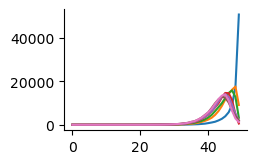

In [46]:
a = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/test/dw11117.pt')
print(len(a))
print(a[-1].shape)
print(np.nanmax(a[-2]))
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
for j in range(0,a[1].shape[1],4):
    pl.plot(a[-1][:,j])
    print(np.sum(a[-1][:,j]))

In [8]:
### Define parameters
swLR = np.logspace(-5,-7/3,9) # Sweep over these learning rates
nSeeds = 5 # No. runs per hyperparameter
seeds = list(sp.primerange(11111,33333))[0:nSeeds] # RNG seeds
complete = torch.zeros((len(swLR), len(seeds)))
for j, lr in enumerate(swLR):
    # if j!=0:
    #     continue
    for k, sd in enumerate(seeds):
        t = time.time()
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = 3
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'FB3_swLR_'+str(j)
        complete[j, k] = xent_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')
        print(f'*************************FB3 Run time: {time.time()-t}')
completeName = directory+'/data/FB3_swLR_0/complete.pt'
torch.save(complete, completeName)

print('*******************************FINISHED FB3********************************')

complete = torch.zeros((len(swLR), len(seeds)))
for j, lr in enumerate(swLR):
    # if j!=0:
    #     continue
    for k, sd in enumerate(seeds):
        t = time.time()
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = 2
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'FB2_swLR_'+str(j)
        complete[j, k] = xent_esn_fb(expName, sd)
        # complete[j, k] = metric_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')
        print(f'*************************FB2 Run time: {time.time()-t}')
completeName = directory+'/data/FB2_swLR_0/complete.pt'
torch.save(complete, completeName)

print('*******************************FINISHED FB2********************************')

complete = torch.zeros((len(swLR), len(seeds)))
for j, lr in enumerate(swLR):
    # if j!=0:
    #     continue
    for k, sd in enumerate(seeds):
        t = time.time()
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = 1
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'FB1_swLR_'+str(j)
        complete[j, k] = xent_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')
        print(f'*************************FB1 Run time: {time.time()-t}')
completeName = directory+'/data/FB1_swLR_0/complete.pt'
torch.save(complete, completeName)

print('*******************************FINISHED FB1********************************')

complete = torch.zeros((len(swLR), len(seeds)))
for j, lr in enumerate(swLR):
    # if j!=0:
    #     continue
    for k, sd in enumerate(seeds):
        t = time.time()
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = []
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'FB0_swLR_'+str(j)
        complete[j, k] = xent_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')
        print(f'*************************FB0 Run time: {time.time()-t}')
completeName = directory+'/data/FB0_swLR_0/complete.pt'
torch.save(complete, completeName)

print('*******************************FINISHED FB0********************************')

**********************START TRAINING
DP = 0.0680989995598793                            DN = 0.08591286092996597                           maxRESP = 0.12253383547067642
DP = 0.061740975826978683                            DN = 0.083063505589962                           maxRESP = 0.10372699052095413
Time per stage: 5.813745021820068
Progress: 0.5%   Mean Tr Er: 1.9901012945175172, Mean Val Er: 1.9906247901916503;   Mean Tr Acc: 0.6260000014305115, Mean Val Acc: 0.6529999995231628, DW: 0.00013727876276727646
DP = 0.08361227810382843                            DN = 0.12986771762371063                           maxRESP = 0.18332485854625702
DP = 0.08477184176445007                            DN = 0.1214631050825119                           maxRESP = 0.1674966663122177
Time per stage: 1.992600679397583
Progress: 1.0%   Mean Tr Er: 1.9799955558776856, Mean Val Er: 1.98119140625;   Mean Tr Acc: 0.6660000014305115, Mean Val Acc: 0.6659999918937684, DW: 2.44161866699382e-05
Time per stage: 2.

# Run parameter sweep (MetricLearning)

In [ ]:
complete=np.ones((9,5))
complete[-1,0:2]=-1
completeName = directory+'/data/met_FB3_swLR_0/complete.pt'
torch.save(complete, completeName)

# Plot data

In [ ]:
# ### Load Triplet data
# inputDir = directory+'/data/'+experiment    # Storage directory for input/label data
# met = torch.load(inputDir + 'met_save.pt')
# l_tri = torch.load(inputDir + 'loss_triplet.pt')
# l_out = torch.load(inputDir + 'loss_out.pt')
# a_tri = torch.load(inputDir + 'acc_triplet.pt')
# a_out = torch.load(inputDir + 'acc_out.pt')
# dist = torch.load(inputDir + 'dist_triplet.pt')
# nt_dist = dist.shape[0] 
# nt_out = l_out.shape[0]
# nt_met = met.shape[0]
# N_triplet=45000
# N_out=5000
# batch_size=64
# eta_t=0.0002
# eta_o = 0.001
# eta_t_tau = 40000.0
# eta_o_tau = 4000.0
# N_class=10
# margin=2
# save_N = 100 #100 # # of saved epochs
# save_every = np.floor(N_triplet / save_N) # Save data every <> epohsChoice 3
# save_Nsamples = 100 # # of inputs from each class for which to save resonses

### Load Classic data
experiment = 'met_FB0_swLR_0'
expDir = directory+'/data/'+experiment # To read in saved data
sd_name='11113'
inputDir = expDir#+'/'+sd_name  
figDir = directory+'/figs/met/'+experiment # To export figures
print(figDir)
if not os.path.exists(figDir):
    os.mkdir(figDir)

RESP = torch.load(inputDir + '/respSave'+sd_name+'.pt')
print(f'Num layers = {len(RESP)}')
lossTr = torch.load(inputDir + '/lossTr'+sd_name+'.pt')
accTr = torch.load(inputDir + '/accTr'+sd_name+'.pt')
accVal = torch.load(inputDir + '/accVal'+sd_name+'.pt')
weights = torch.load(inputDir + '/weightSave'+sd_name+'.pt')
nt = RESP[0].shape[-1]
kernel = np.ones(50)/50

### Set figure properties
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams.update({'font.size': 6})
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['savefig.format'] = 'svg'
matplotlib.rcParams['font.family'] = 'sans-serif'

In [ ]:
weights.shape

In [ ]:
# saveflag = True
saveflag = False

# fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
# ax.spines[['top','right']].set_visible(False)
# layer = 2
# c=0
# times=[0, 4]

# ### Plot responses
# # t=0
# # for i in range(c*par.nClass,(c+1)*par.nClass):
# #             pl.plot(RESP[layer][t,i,::10,:].transpose(), linewidth=0.5)
# for c in [0, 1, 9]:
#     for j, t in enumerate(times):
#         for i in range(c*par.nClass,(c+1)*par.nClass):
#             pl.plot(RESP[layer][t,i,:,:].transpose(), linewidth=0.5)
#         if j==0:
#             ax.xaxis.set_ticks((0,nt)); ax.yaxis.set_ticks((0,0.2))
#         elif j==1:
#             ax.xaxis.set_ticks((0,nt)); ax.yaxis.set_ticks((0,10,20))
#         if saveflag:
#             pl.savefig(figDir+'/resp_c'+str(c)+'t'+str(j)+'.svg', format="svg")
#         ax.cla() 

# ### Plot accuracy
# fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
# ax.spines[['top','right']].set_visible(False)
# pl.plot(np.linspace(1,par.nEpochs,par.nEpochs),np.convolve(np.pad(accTr, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0)
# pl.plot(np.linspace(1,par.nEpochs,par.nEpochs),np.convolve(np.pad(accVal, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0)
# # pl.plot(accTr, linewidth=0.5); pl.plot(accVal, linewidth=0.5)
# ax.xaxis.set_ticks((0,par.nEpochs)); ax.yaxis.set_ticks((0,1))
# if saveflag:
#     pl.savefig(figDir+'/accTrVal.svg', format="svg")

### Plot Feedback Weight Evolution
if par.saveFlag_FBWeights:
    fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
    ax.spines[['top','right']].set_visible(False)
    for j in range(0,1000,100):
        pl.plot(np.linspace(1,par.nEpochs,par.nSave+1),weights[::2,j,:].transpose(), linewidth=0.5)
ax.xaxis.set_ticks((0,par.nEpochs)); ax.yaxis.set_ticks((-.05,0,.05))
if saveflag:
    pl.savefig(figDir+'/fbWeights.svg', format="svg")

# ### Correlation between met responses
# layer = 1
# fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
# # imdata = ax.imshow(stats.zscore(np.reshape(RESP[1][0,:,:,:],[RESP[1].shape[1], RESP[1].shape[2]*RESP[1].shape[3]]), 1).transpose(),vmin=-1.0, vmax=1.0)
# c0 = np.matmul(stats.zscore(np.reshape(RESP[layer][0,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1), stats.zscore(np.reshape(RESP[layer][0,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1).transpose()) / (RESP[layer].shape[2])
# imdata = ax.imshow(c0,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
# if saveflag:
#     pl.savefig(directory+'/figs/'+prefix+'met0_corr.svg', format="svg")
# fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
# c1 = np.matmul(stats.zscore(np.reshape(RESP[layer][19,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1), stats.zscore(np.reshape(RESP[layer][19,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1).transpose()) / (RESP[layer].shape[2])
# imdata = ax.imshow(c1,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
# if saveflag:
#     pl.savefig(directory+'/figs/'+prefix+'met1_corr.svg', format="svg") 


### Plot triplet distances and loss

In [ ]:
import matplotlib
from matplotlib import pyplot as pl
# saveflag = True
saveflag = False
tripletflag = True
# tripletflag = False

kernel = np.ones(50)/50
prefix = experiment#'classic_original_'
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['axes.labelsize'] = 6
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['savefig.format'] = 'svg'
matplotlib.rcParams['font.family'] = 'sans-serif'

###Plot distances
if tripletflag:
  fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
  ax.spines[['top','right']].set_visible(False)
  # pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),dist[:,0]); pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),dist[:,1], linestyle='dashed')
  pl.plot(np.linspace(1,nt_dist,nt_dist),dist[:,0], linewidth=0.5)
  pl.plot(np.linspace(1,nt_dist,nt_dist),dist[:,1], linewidth=0.5)
  ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=20)
  # ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,15,30))
  ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,20))
  # ax.tick_params(axis='both', which='major', labelsize=6.0)
  if saveflag:
      pl.savefig(directory+'/figs/'+prefix+'distances.svg', format="svg")

###Plot triplett loss
if tripletflag:
  fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
  ax.spines[['top','right']].set_visible(False)
  # pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),l_tri); pl.plot(np.log10(np.linspace(1,nt_dist,nt_distX_tr.shape)),np.convolve(l_tri,kernel,mode='same')); 
  pl.plot(np.linspace(1,nt_dist,nt_dist),l_tri, linewidth=0.5)
  pl.plot(np.linspace(1,nt_dist,nt_dist),np.convolve(np.pad(l_tri, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
  # ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=0.5*1.05*np.max(l_tri))
  ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=1.0)
  # ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
  ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,1))
  ax.tick_params(axis='both', which='major', labelsize=6.0)
  if saveflag:
      pl.savefig(directory+'/figs/'+prefix+'loss_triplet.svg', format="svg")

###Plot triplet accuracy
if tripletflag:
  fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
  ax.spines[['top','right']].set_visible(False)
  pl.plot(np.linspace(1,nt_dist,nt_dist),a_tri*100, linewidth=0.5)
  pl.plot(np.linspace(1,nt_dist,nt_dist),np.convolve(np.pad(a_tri*100, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
  ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=100.)
  # ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
  ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,100))
  ax.tick_params(axis='both', which='major', labelsize=6.0)
  if saveflag:
      pl.savefig(directory+'/figs/'+prefix+'acc_triplet.svg', format="svg")

###Plot output loss
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
# pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),l_tri); pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),np.convolve(l_tri,kernel,mode='same')); 
pl.plot(np.linspace(1,nt_out,nt_out),l_out, linewidth=0.5)
pl.plot(np.linspace(1,nt_out,nt_out),np.convolve(np.pad(l_out, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_out)); ax.set_ylim(ymin=0.0, ymax=0.8)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_out)); ax.yaxis.set_ticks((0.0,0.8))
ax.tick_params(axis='both', which='major', labelsize=6.0)
ax.set_xticklabels((0, nt_out), fontdict={'family': 'sans-serif', 'size':5})
ax.set_yticklabels((0.5,0.8), fontdict={'family': 'sans-serif', 'size':5})
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'loss_out.svg', format="svg")

###Plot output accuracy
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt_out,nt_out),a_out*100, linewidth=0.5)
pl.plot(np.linspace(1,nt_out,nt_out),np.convolve(np.pad(a_out*100, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_out)); ax.set_ylim(ymin=0.0, ymax=100.)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_out)); ax.yaxis.set_ticks((0,100))
ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'acc_out.svg', format="svg")

### Plot met responses over training

In [ ]:
from matplotlib import pyplot as pl
from scipy import stats
pl.rcParams['savefig.dpi'] = 400

saveflag = True
# saveflag = False

### Raw met reponses
fig = pl.figure(figsize=tuple(np.array((6.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
plmet = np.squeeze(met[0,:,199])
pl.plot(np.linspace(1,nt_met,nt_met)*save_every,plmet)
ax.set_xlim(xmin=0, xmax=nt_met*save_every); ax.set_ylim(ymin=0.0, ymax=1.05*np.max(plmet))
ax.xaxis.set_ticks((0,nt_met*save_every)); ax.yaxis.set_ticks((0,))
pl.show()

fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
c0 = stats.zscore(np.squeeze(met[0,:,:]),0)
imdata = ax.imshow(c0,vmin=0.0, vmax=2.0)
cb = fig.colorbar(imdata, ticks=[0., 2.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met0.svg', format="svg")
fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
c0 = stats.zscore(np.squeeze(met[-1,:,:]),0)
imdata = ax.imshow(c0,vmin=0.0, vmax=2.0)
cb = fig.colorbar(imdata, ticks=[0., 2.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met1.svg', format="svg")

### Correlation between met responses
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
c0 = np.matmul(stats.zscore(np.squeeze(met[0,:,:]),0).transpose(), stats.zscore(np.squeeze(met[0,:,:]),0)) / met.shape[1]
imdata = ax.imshow(c0,vmin=-1.0, vmax=1.0)
cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met0_corr.svg', format="svg")
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
c1 = np.matmul(stats.zscore(np.squeeze(met[-1,:,:]),0).transpose(), stats.zscore(np.squeeze(met[-1,:,:]),0)) / met.shape[1]
imdata = ax.imshow(c1,vmin=-1.0, vmax=1.0)
cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met1_corr.svg', format="svg") 


# Plot weights